In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [14]:
def computeParentPercent(experimentData,parent,column):
    #get all lines for this parent
    sons=experimentData[experimentData['Parent']==parent]
    declaredTotal = experimentData[experimentData['#name'] == parent][column]
    computedTotal = sum(sons[column])
    newColumnName = column + "_parentPercent"
    newColumn = sons[column]/computedTotal
    sons[newColumnName] = newColumn
    
    return sons
    


In [15]:
def computeParentPercentAll(experimentData):
    #add columns we need

    #experimentData['totParent']=np.nan
    
    #make som totals
    asd = experimentData.groupby(['Parent','Section']).aggregate(sum)
    asd = experimentData[experimentData.Section == "BODY"].groupby('Parent').aggregate(sum)
    asd.rename(columns={'cpuTime':'parentCpuTime','wallTime':'parentWallTime','Calls':'parentCalls'},inplace=True)
    
 
    experimentData = pd.merge(experimentData , asd , how='left', right_index=True, left_on='Parent')
    
    experimentData['wallTime_parentPercent']=np.nan
    experimentData['cpuTime_parentPercent']=np.nan
    experimentData['calls_parentPercent']=np.nan
    
    experimentData.cpuTime_parentPercent = experimentData.cpuTime / experimentData.parentCpuTime * 100
    experimentData.wallTime_parentPercent = experimentData.wallTime / experimentData.parentWallTime * 100
    experimentData.calls_parentPercent = experimentData.Calls / experimentData.parentCalls * 100
    return experimentData
    

In [16]:
datas = pd.read_csv('Co3O4-H2-conf1-scf.csv', skiprows=3,header=0)

In [17]:
#computeParentPercent(datas,'electrons','cpuTime')
#computeParentPercent(datas,'electrons','wallTime')

datas = computeParentPercentAll(datas)
datas

,#name,cpuTime,wallTime,Calls,Parent,Section,parentCpuTime,parentWallTime,parentCalls,wallTime_parentPercent,cpuTime_parentPercent,calls_parentPercent
0,init_run,24780,25750,1,NaN,BODY,NaN,NaN,NaN,NaN,NaN,NaN
1,electrons,1636950,1711640,1,NaN,BODY,NaN,NaN,NaN,NaN,NaN,NaN
2,forces,18630,19450,1,NaN,BODY,NaN,NaN,NaN,NaN,NaN,NaN
3,wfcinit,10550,10730,1,init_run,BODY,12540,12880,2,83.307453,84.130781,50.000000
4,potinit,1990,2150,1,init_run,BODY,12540,12880,2,16.692547,15.869219,50.000000
5,c_bands,911620,923390,52,electrons,BODY,1722920,1801290,369,51.262706,52.911337,14.092141
6,sum_band,472900,501600,52,electrons,BODY,1722920,1801290,369,27.846710,27.447589,14.092141
7,v_of_rho,87050,91410,53,electrons,BODY,1722920,1801290,369,5.074696,5.052469,14.363144
8,v_h,2870,3020,53,electrons,BODY,1722920,1801290,369,0.167658,0.166578,14.363144
9,v_xc,85760,90050,54,electrons,BODY,1722920,1801290,369,4.999195,4.977596,14.634146


In [18]:
#time to plot
toPlot = datas[ datas.Parent == 'electrons'][['#name','cpuTime_parentPercent']].set_index('#name') 

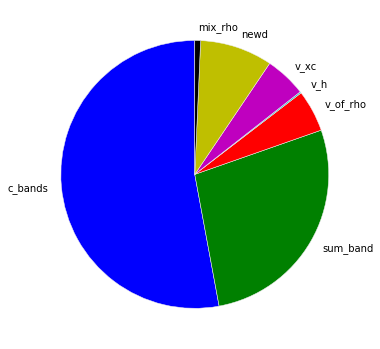

In [19]:
#toPlot.plot(kind='pie',subplots=True)
#use matplotlib for more controll
plt.figure(figsize=(6,6))
plt.pie(toPlot,labels = toPlot.index,startangle=90)
plt.show()

#the idea is to make a pie or a bar plot for every parent and make a nice figure

In [20]:
toBarPlot = datas[(datas.Parent == "electrons") & (datas.Section == "BODY")][['#name','Parent','cpuTime_parentPercent','wallTime_parentPercent','calls_parentPercent']]
toBarPlot

,#name,Parent,cpuTime_parentPercent,wallTime_parentPercent,calls_parentPercent
5,c_bands,electrons,52.911337,51.262706,14.092141
6,sum_band,electrons,27.447589,27.846710,14.092141
7,v_of_rho,electrons,5.052469,5.074696,14.363144
8,v_h,electrons,0.166578,0.167658,14.363144
9,v_xc,electrons,4.977596,4.999195,14.634146
10,newd,electrons,8.746779,9.977294,14.363144
11,mix_rho,electrons,0.697653,0.671741,14.092141


In [21]:
toBarPlot

,#name,Parent,cpuTime_parentPercent,wallTime_parentPercent,calls_parentPercent
5,c_bands,electrons,52.911337,51.262706,14.092141
6,sum_band,electrons,27.447589,27.846710,14.092141
7,v_of_rho,electrons,5.052469,5.074696,14.363144
8,v_h,electrons,0.166578,0.167658,14.363144
9,v_xc,electrons,4.977596,4.999195,14.634146
10,newd,electrons,8.746779,9.977294,14.363144
11,mix_rho,electrons,0.697653,0.671741,14.092141


In [22]:
#sort by most cpu demanding
toBarPlot.sort_values('cpuTime_parentPercent',ascending = False, inplace=True)

In [23]:
cpuOffsets = [0]
wallOffsets = [0]
callsOffsets = [0]
for i,j,z in zip(toBarPlot.cpuTime_parentPercent,toBarPlot.wallTime_parentPercent,toBarPlot.calls_parentPercent) :
    cpuOffsets.append(cpuOffsets[len(cpuOffsets)-1] + i)
    wallOffsets.append(wallOffsets[len(wallOffsets)-1] + j)
    callsOffsets.append(callsOffsets[len(callsOffsets)-1] + z)
cpuOffsets = cpuOffsets[:-1]
wallOffsets = wallOffsets[:-1]
callsOffsets = callsOffsets[:-1]

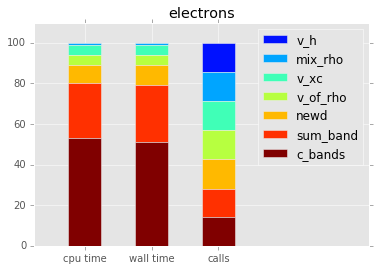

In [28]:
cmap = plt.cm.jet
zipped = zip(toBarPlot['#name'],
             toBarPlot.cpuTime_parentPercent,toBarPlot.wallTime_parentPercent,toBarPlot.calls_parentPercent,
             cpuOffsets,wallOffsets,callsOffsets,
             range(0,len(toBarPlot['#name'])))
#print in reverse order because we wnat the bottom stack to be the least in the legend
#unfortunately managing the legend order is not so easy
for name,cpu,wall,calls,cpuO,wallO,callsO,nth in reversed(zipped):
    plt.bar([1,3,5], #position of the bar
           [cpu,wall,calls],#height
           width=1,
           bottom=[cpuO,wallO,callsO],
            color = cmap(1- (float(nth)/len(toBarPlot['#name']))),
            label = name 
          )

plt.xlim(0,10)
plt.ylim(0,110)
plt.title(toBarPlot.iloc[0].Parent)
plt.xticks([1.5,3.5,5.5],['cpu time','wall time','calls'])
plt.legend()